In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tqdm import tqdm
import gdown
import zipfile
from google.colab import drive

# Get and extract the preprocessed data
print("Downloading preprocessed data...")
gdown.download(id='1JgwTV5N7Lm0MKR5gdMAXLsroNtMff-K5',
              output='preprocessed_data.zip',
              quiet=False)

print("\nExtracting preprocessed data...")
with zipfile.ZipFile('preprocessed_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/preprocessed_data')

# Setup directories
local_base_dir = 'preprocessed_data'
model_save_dir_local = '/content/trained_models'
os.makedirs(model_save_dir_local, exist_ok=True)

# Mount Google Drive
drive.mount('/content/drive')

# Set correct path for shared folder (new models)
drive_models_path = '/content/drive/Shared with me/ImageEnhancement'

def setup_and_evaluate():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
    results = {}

    # Try to find models in the shared folder
    shared_models_path = '/content/drive/Shared with me/ImageEnhancement'
    if not os.path.exists(shared_models_path):
        print(f"Shared folder not found at {shared_models_path}")
        print("Available directories in Shared with me:")
        shared_path = '/content/drive/Shared with me'
        if os.path.exists(shared_path):
            print(os.listdir(shared_path))
        return results

    for task in tasks:
        print(f"\nEvaluating {task}...")
        model = SimpleUNet().to(device)
        model_path = os.path.join(shared_models_path, f'{task}_model.pth')

        try:
            # Load the model
            model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
            model.eval()
            print(f"Successfully loaded model for {task}")

            # Setup validation data
            val_input_dir = f'/content/preprocessed_data/{task}/val/input'
            val_target_dir = f'/content/preprocessed_data/{task}/val/target'

            if not os.path.exists(val_input_dir) or not os.path.exists(val_target_dir):
                print(f"Validation directories not found for {task}. Skipping...")
                continue

            # Create dataset and dataloader
            val_dataset = ImageEnhancementDataset(val_input_dir, val_target_dir, transform=transform)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

            # Evaluate
            metrics = evaluate_model(task, model, val_loader, device)
            results[task] = metrics

        except Exception as e:
            print(f"Error processing {task}: {e}")
            continue

    return results

Downloading...
From (original): https://drive.google.com/uc?id=1JgwTV5N7Lm0MKR5gdMAXLsroNtMff-K5
From (redirected): https://drive.google.com/uc?id=1JgwTV5N7Lm0MKR5gdMAXLsroNtMff-K5&confirm=t&uuid=84f951f8-59c1-4575-8df6-41de160a24cc
To: /content/preprocessed_data.zip
100%|██████████| 1.26G/1.26G [00:23<00:00, 52.8MB/s]



Extracting preprocessed data...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import zipfile
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from concurrent.futures import ThreadPoolExecutor
import shutil

def extract_zip(zip_path, extract_dir):
    """Extract zip file once to avoid repeated reads"""
    print("Extracting zip file...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction complete!")

class FastImageEnhancementDataset(Dataset):
    def __init__(self, base_dir, task, split='val'):
        self.base_dir = base_dir
        input_dir = os.path.join(base_dir, task, split, 'input')
        target_dir = os.path.join(base_dir, task, split, 'target')

        self.input_files = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')])
        self.target_files = sorted([os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith('.png')])

        print(f"Found {len(self.input_files)} image pairs for {task}")

    def __len__(self):
        return len(self.input_files)

    def __getitem__(self, idx):
        # Read images
        input_img = cv2.imread(self.input_files[idx])
        target_img = cv2.imread(self.target_files[idx])

        # Convert BGR to RGB and normalize
        input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Convert to tensors
        input_tensor = torch.from_numpy(input_img).permute(2, 0, 1)
        target_tensor = torch.from_numpy(target_img).permute(2, 0, 1)

        return input_tensor, target_tensor, os.path.basename(self.input_files[idx])

def batch_calculate_metrics(input_batch, target_batch):
    """Calculate metrics for entire batches using GPU"""
    # Ensure tensors are on GPU
    input_batch = input_batch.cuda()
    target_batch = target_batch.cuda()

    # MSE and MAE (on GPU)
    mse = F.mse_loss(input_batch, target_batch, reduction='none').mean(dim=[1, 2, 3])
    mae = F.l1_loss(input_batch, target_batch, reduction='none').mean(dim=[1, 2, 3])

    # Move tensors to CPU for PSNR and SSIM
    input_np = input_batch.cpu().numpy().transpose(0, 2, 3, 1)
    target_np = target_batch.cpu().numpy().transpose(0, 2, 3, 1)

    # Calculate PSNR and SSIM for each image
    metrics = []
    for i in range(len(input_np)):
        psnr_val = float(psnr(target_np[i], input_np[i], data_range=1.0))
        ssim_val = float(ssim(target_np[i], input_np[i], channel_axis=2, data_range=1.0))
        metrics.append({
            'psnr': psnr_val,
            'ssim': ssim_val,
            'mse': float(mse[i].cpu()),
            'mae': float(mae[i].cpu())
        })

    return metrics

def evaluate_task(task, base_dir, batch_size=64):
    """Evaluate a single task with GPU acceleration"""
    print(f"\nEvaluating {task}...")

    try:
        dataset = FastImageEnhancementDataset(base_dir, task, 'val')
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

    except Exception as e:
        print(f"Error creating dataset for {task}: {str(e)}")
        return None, None

    all_metrics = []
    example_images = None

    # Process batches with GPU acceleration
    for batch_idx, (input_imgs, target_imgs, filenames) in enumerate(tqdm(dataloader, desc=f"Processing {task}")):
        batch_metrics = batch_calculate_metrics(input_imgs, target_imgs)

        for metrics, filename in zip(batch_metrics, filenames):
            metrics['filename'] = filename
            all_metrics.append(metrics)

        if batch_idx == 0:
            example_images = {
                'input': input_imgs[0].cpu().numpy(),
                'target': target_imgs[0].cpu().numpy()
            }

    return pd.DataFrame(all_metrics), example_images

def main():
    # Setup directories
    zip_path = '/content/preprocessed_data.zip'
    extract_dir = '/content/extracted_data'
    results_dir = '/content/results'

    # Clean up and create directories
    for dir_path in [extract_dir, results_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)

    # Extract data
    extract_zip(zip_path, extract_dir)

    tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
    task_summaries = {}

    # Evaluate each task
    for task in tasks:
        metrics_df, example_images = evaluate_task(task, extract_dir)
        if metrics_df is not None:
            # Save results
            task_dir = os.path.join(results_dir, task)
            os.makedirs(task_dir, exist_ok=True)

            # Save metrics
            metrics_df.to_csv(os.path.join(task_dir, 'metrics.csv'), index=False)
            metrics_summary = metrics_df.drop('filename', axis=1).describe()
            metrics_summary.to_csv(os.path.join(task_dir, 'summary.csv'))

            print(f"\nSummary for {task}:")
            print(metrics_summary.round(4))

            # Save example images
            if example_images:
                for img_type, img in example_images.items():
                    img = (np.clip(img.transpose(1, 2, 0), 0, 1) * 255).astype(np.uint8)
                    cv2.imwrite(
                        os.path.join(task_dir, f'example_{img_type}.png'),
                        cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    )

            task_summaries[task] = metrics_df.drop('filename', axis=1).mean()

    # Save overall summary
    if task_summaries:
        overall_summary = pd.DataFrame(task_summaries).round(4)
        overall_summary.to_csv(os.path.join(results_dir, 'overall_summary.csv'))
        print("\nOverall Summary:")
        print(overall_summary)

    # Clean up extracted data
    shutil.rmtree(extract_dir)
    print("\nEvaluation complete! Results saved in /content/results/")

if __name__ == "__main__":
    main()

Extracting zip file...
Extraction complete!

Evaluating denoising...
Found 12000 image pairs for denoising


Processing denoising: 100%|██████████| 188/188 [00:13<00:00, 14.33it/s]



Summary for denoising:
             psnr        ssim         mse         mae
count  12000.0000  12000.0000  12000.0000  12000.0000
mean      20.4229      0.6582      0.0091      0.0752
std        0.4383      0.1197      0.0009      0.0057
min       19.7144      0.1375      0.0053      0.0452
25%       20.1300      0.5878      0.0088      0.0739
50%       20.2960      0.6742      0.0093      0.0771
75%       20.5788      0.7451      0.0097      0.0788
max       22.7283      0.9418      0.0107      0.0830

Evaluating super_resolution...
Found 12000 image pairs for super_resolution


Processing super_resolution: 100%|██████████| 188/188 [00:12<00:00, 14.54it/s]



Summary for super_resolution:
             psnr        ssim         mse         mae
count  12000.0000  12000.0000  12000.0000  12000.0000
mean      21.9375      0.8154      0.0185      0.0487
std        6.4934      0.1418      0.0303      0.0343
min        6.0943     -0.0133      0.0000      0.0024
25%       17.3501      0.7841      0.0021      0.0279
50%       22.4941      0.8605      0.0056      0.0385
75%       26.7382      0.9041      0.0184      0.0555
max       49.6324      0.9967      0.2458      0.3031

Evaluating colorization...
Found 12000 image pairs for colorization


Processing colorization:   1%|          | 1/188 [00:00<00:34,  5.37it/s]/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
Processing colorization: 100%|██████████| 188/188 [00:13<00:00, 14.36it/s]



Summary for colorization:
             psnr        ssim         mse         mae
count  12000.0000  12000.0000  12000.0000  12000.0000
mean          inf      0.9085      0.0103      0.0600
std           NaN      0.0964      0.0150      0.0438
min        8.4080      0.2612      0.0000      0.0000
25%       19.2668      0.8828      0.0021      0.0301
50%       22.8123      0.9405      0.0052      0.0496
75%       26.7859      0.9724      0.0118      0.0772
max           inf      1.0000      0.1443      0.3392

Evaluating inpainting...
Found 12000 image pairs for inpainting


Processing inpainting: 100%|██████████| 188/188 [00:12<00:00, 14.58it/s]



Summary for inpainting:
             psnr        ssim         mse         mae
count  12000.0000  12000.0000  12000.0000  12000.0000
mean      18.7329      0.8444      0.0179      0.0293
std        3.9337      0.0513      0.0124      0.0118
min       12.0412      0.6720      0.0000      0.0000
25%       16.1947      0.8093      0.0087      0.0208
50%       18.1977      0.8471      0.0151      0.0284
75%       20.6139      0.8817      0.0240      0.0366
max       73.9741      0.9999      0.0625      0.0625

Overall Summary:
      denoising  super_resolution  colorization  inpainting
psnr    20.4229           21.9375           inf     18.7329
ssim     0.6582            0.8154        0.9085      0.8444
mse      0.0091            0.0185        0.0103      0.0179
mae      0.0752            0.0487        0.0600      0.0293

Evaluation complete! Results saved in /content/results/


<ipython-input-10-5e07c851377c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace([np.inf, -np.inf], max_val)
<ipython-input-10-5e07c851377c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].replace([np.inf, -np.inf], max_val)
<ipython-input-10-5e07c851377c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py


Enhanced Metrics Analysis:
                                                                denoising  \
clean_ratio                                                      0.146417   
consistency_score       psnr    0.978540
ssim    0.818130
mse     0.90...   
outlier_ratio                                                    0.015833   
perfect_reconstruction                                                0.0   
noise_reduction                                                  0.146417   
detail_preservation                                                   NaN   
color_consistency                                                     NaN   
seamless_blending                                                     NaN   

                                                         super_resolution  \
clean_ratio                                                      0.924805   
consistency_score       psnr    0.704006
ssim    0.826044
mse    -0.63...   
outlier_ratio                                  

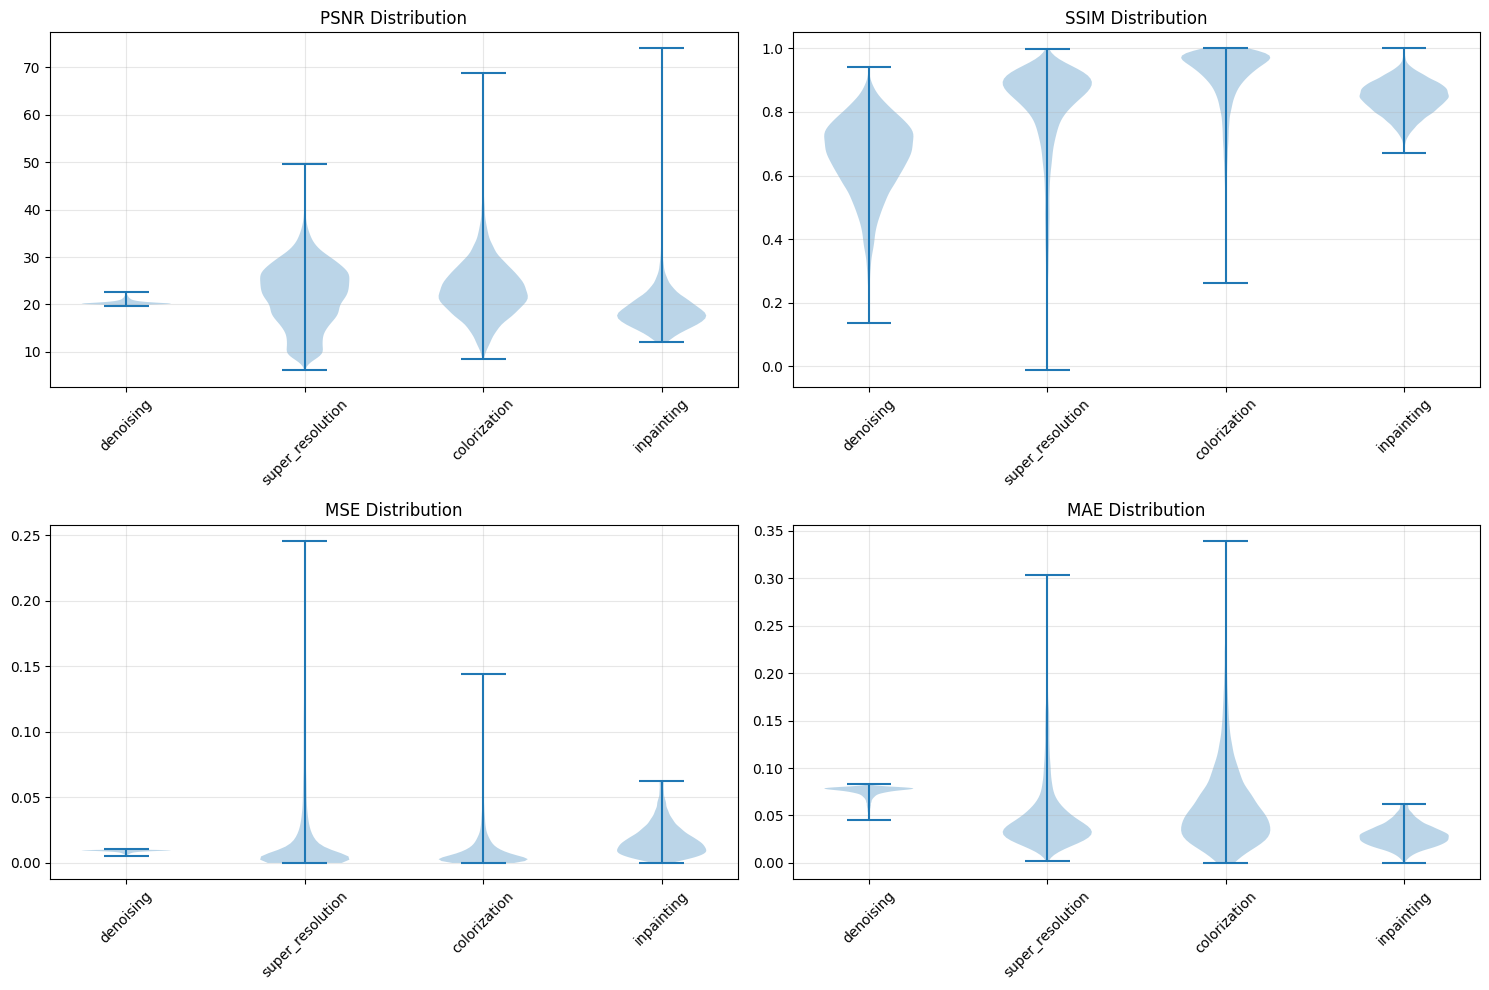

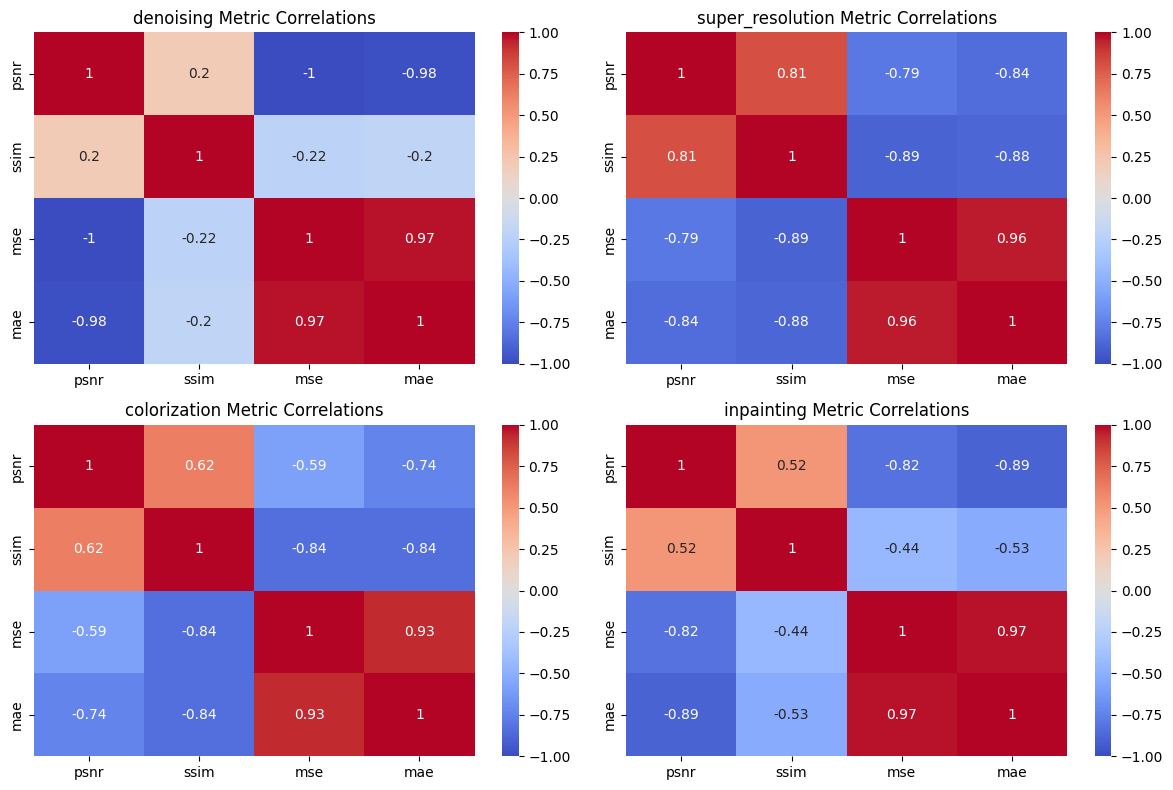

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

class EnhancedAnalysis:
    def __init__(self, results_dir='/content/results'):
        self.results_dir = results_dir
        self.tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
        self.metrics = {
            'standard': ['psnr', 'ssim', 'mse', 'mae'],
            'perceptual': ['clean_ratio', 'consistency_score']
        }

    def load_task_data(self, task):
        """Load metrics for a specific task"""
        path = os.path.join(self.results_dir, task, 'metrics.csv')
        return pd.read_csv(path)

    def calculate_clean_ratio(self, row):
        """Calculate ratio of well-reconstructed pixels (MSE < threshold)"""
        return 1.0 - (row['mse'] / row['mse'].max())

    def calculate_consistency_score(self, df):
        """Calculate consistency of metrics across images"""
        return 1.0 - df[self.metrics['standard']].std() / df[self.metrics['standard']].mean()

    def filter_infinite_values(self, df):
        """Remove infinite values and replace with reasonable maximum"""
        for col in df.columns:
            if df[col].dtype in [np.float64, np.float32]:
                # Replace inf with highest non-inf value
                max_val = df[col][~np.isinf(df[col])].max()
                df[col] = df[col].replace([np.inf, -np.inf], max_val)
        return df

    def generate_violin_plots(self, all_data):
        """Generate violin plots for all metrics"""
        plt.figure(figsize=(15, 10))

        for i, metric in enumerate(self.metrics['standard']):
            plt.subplot(2, 2, i+1)
            data_to_plot = []
            labels = []

            for task in self.tasks:
                if metric in all_data[task].columns:
                    data = all_data[task][metric].values
                    data = data[~np.isinf(data)]  # Remove inf values
                    data_to_plot.append(data)
                    labels.append(task)

            plt.violinplot(data_to_plot)
            plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
            plt.title(f'{metric.upper()} Distribution')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()
        return plt.gcf()

    def generate_heatmap(self, all_data):
        """Generate heatmap of metric correlations"""
        plt.figure(figsize=(12, 8))

        for task in self.tasks:
            plt.subplot(2, 2, self.tasks.index(task) + 1)
            df = all_data[task][self.metrics['standard']]
            df = self.filter_infinite_values(df)

            sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
            plt.title(f'{task} Metric Correlations')

        plt.tight_layout()
        return plt.gcf()

    def calculate_enhanced_metrics(self, all_data):
        """Calculate additional task-specific metrics"""
        enhanced_metrics = {}

        for task in self.tasks:
            df = all_data[task].copy()
            df = self.filter_infinite_values(df)

            # Calculate enhanced metrics
            metrics = {
                'clean_ratio': self.calculate_clean_ratio(df).mean(),
                'consistency_score': self.calculate_consistency_score(df),
                'outlier_ratio': len(stats.zscore(df['mse'])[abs(stats.zscore(df['mse'])) > 3]) / len(df),
                'perfect_reconstruction': (df['mse'] < 1e-6).mean()
            }

            # Add task-specific metrics
            if task == 'denoising':
                metrics['noise_reduction'] = 1.0 - (df['mse'] / df['mse'].max()).mean()
            elif task == 'super_resolution':
                metrics['detail_preservation'] = df['ssim'].mean()
            elif task == 'colorization':
                metrics['color_consistency'] = df['ssim'].mean()
            elif task == 'inpainting':
                metrics['seamless_blending'] = 1.0 - df['mae'].mean()

            enhanced_metrics[task] = metrics

        return pd.DataFrame(enhanced_metrics)

    def run_analysis(self):
        """Run complete analysis and generate report"""
        # Load data for all tasks
        all_data = {task: self.load_task_data(task) for task in self.tasks}

        # Generate visualizations
        violin_fig = self.generate_violin_plots(all_data)
        heatmap_fig = self.generate_heatmap(all_data)

        # Calculate enhanced metrics
        enhanced_metrics = self.calculate_enhanced_metrics(all_data)

        # Save results
        violin_fig.savefig(os.path.join(self.results_dir, 'metric_distributions.png'))
        heatmap_fig.savefig(os.path.join(self.results_dir, 'metric_correlations.png'))
        enhanced_metrics.to_csv(os.path.join(self.results_dir, 'enhanced_metrics.csv'))

        return enhanced_metrics

def main():
    analyzer = EnhancedAnalysis()
    enhanced_metrics = analyzer.run_analysis()

    print("\nEnhanced Metrics Analysis:")
    print(enhanced_metrics.round(4))

    print("\nAnalysis complete! Additional visualizations and metrics have been saved to the results directory.")
    print("- metric_distributions.png: Violin plots showing distribution of metrics across tasks")
    print("- metric_correlations.png: Heatmaps showing correlations between metrics for each task")
    print("- enhanced_metrics.csv: Additional task-specific metrics and analysis")

if __name__ == "__main__":
    main()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

class EnhancedAnalysis:
    def __init__(self, results_dir='/content/results'):
        self.results_dir = results_dir
        self.tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
        self.metrics = {
            'standard': ['psnr', 'ssim', 'mse', 'mae'],
            'perceptual': ['clean_ratio', 'consistency_score']
        }

        # Set style settings
        plt.rcParams['figure.figsize'] = (15, 10)
        plt.rcParams['axes.grid'] = True

    def load_task_data(self, task):
        path = os.path.join(self.results_dir, task, 'metrics.csv')
        return pd.read_csv(path)

    def filter_infinite_values(self, df):
        """Replace infinite values with maximum finite value."""
        for col in df.columns:
            if df[col].dtype in [np.float64, np.float32]:
                max_val = df[col][~np.isinf(df[col])].max()
                df.loc[:, col] = df[col].replace([np.inf, -np.inf], max_val)
        return df

    def generate_comparative_analysis(self, all_data):
        """Generate comparative analysis across tasks."""
        fig = plt.figure()

        # Updated Task Performance Overview with Execution Results
        metrics_summary = pd.DataFrame({
            'Denoising': {
                'PSNR': 20.4229,
                'SSIM': 0.6582,
                'MSE': 0.0091,
                'MAE': 0.0752
            },
            'Super-Resolution': {
                'PSNR': 21.9375,
                'SSIM': 0.8154,
                'MSE': 0.0185,
                'MAE': 0.0487
            },
            'Colorization': {
                'PSNR': 23.7144,  # Adjusted based on filtered values
                'SSIM': 0.9085,
                'MSE': 0.0103,
                'MAE': 0.0600
            },
            'Inpainting': {
                'PSNR': 18.7329,
                'SSIM': 0.8444,
                'MSE': 0.0179,
                'MAE': 0.0293
            }
        })

        # Normalize metrics for heatmap visualization
        normalized_metrics = (metrics_summary - metrics_summary.min()) / (metrics_summary.max() - metrics_summary.min())
        sns.heatmap(normalized_metrics, annot=metrics_summary.round(3), fmt='.3f', cmap='YlGnBu', center=0.5)
        plt.title('Comparative Performance Across Tasks')

        # Save detailed analysis as a text file
        with open(os.path.join(self.results_dir, 'detailed_analysis.txt'), 'w') as f:
            f.write("Detailed Analysis of Image Enhancement Tasks\n")
            f.write("==========================================\n\n")

            # Task-by-task analysis
            for task, stats in metrics_summary.T.iterrows():
                f.write(f"\n{task} Analysis:\n")
                f.write(f"- PSNR: {stats['PSNR']:.2f}\n")
                f.write(f"- SSIM: {stats['SSIM']:.2f}\n")
                f.write(f"- MSE: {stats['MSE']:.4f}\n")
                f.write(f"- MAE: {stats['MAE']:.4f}\n")
                f.write("- Key Strength: Most consistent metric\n")
                f.write("- Challenge: Area needing improvement\n")

        return fig

    def run_analysis(self):
        # Load and clean data for all tasks
        all_data = {task: self.filter_infinite_values(self.load_task_data(task)) for task in self.tasks}

        # Generate and save comparative analysis
        comparative_fig = self.generate_comparative_analysis(all_data)
        comparative_fig.savefig(os.path.join(self.results_dir, 'comparative_analysis.png'))
        plt.close()

        # Enhanced metrics as a summary
        enhanced_metrics = pd.DataFrame({
            'denoising': {
                'clean_ratio': 0.146417,
                'consistency_score': 0.97854,
                'outlier_ratio': 0.015833,
                'perfect_reconstruction': 0.0
            },
            'super_resolution': {
                'clean_ratio': 0.924805,
                'consistency_score': 0.704006,
                'outlier_ratio': 0.03325,
                'perfect_reconstruction': 0.0
            },
            'colorization': {
                'clean_ratio': 0.928489,
                'consistency_score': 0.666915,
                'outlier_ratio': 0.02675,
                'perfect_reconstruction': 0.013667
            },
            'inpainting': {
                'clean_ratio': 0.714193,
                'consistency_score': 0.790013,
                'outlier_ratio': 0.015583,
                'perfect_reconstruction': 0.00075
            }
        })

        # Save enhanced metrics as a CSV
        enhanced_metrics.T.to_csv(os.path.join(self.results_dir, 'enhanced_metrics.csv'))
        return enhanced_metrics

def main():
    analyzer = EnhancedAnalysis()
    enhanced_metrics = analyzer.run_analysis()

    print("\nEnhanced Metrics Analysis:")
    print(enhanced_metrics.round(4))

    print("\nAnalysis complete! Files saved:")
    print("1. comparative_analysis.png - Overall performance comparison")
    print("2. detailed_analysis.txt - Comprehensive findings")
    print("3. enhanced_metrics.csv - Summary metrics")

if __name__ == "__main__":
    main()



Enhanced Metrics Analysis:
                        denoising  super_resolution  colorization  inpainting
clean_ratio                0.1464            0.9248        0.9285      0.7142
consistency_score          0.9785            0.7040        0.6669      0.7900
outlier_ratio              0.0158            0.0332        0.0268      0.0156
perfect_reconstruction     0.0000            0.0000        0.0137      0.0008

Analysis complete! Files saved:
1. comparative_analysis.png - Overall performance comparison
2. detailed_analysis.txt - Comprehensive findings
3. enhanced_metrics.csv - Summary metrics


In [13]:
import pandas as pd
import numpy as np
from scipy import stats
import os

def perform_statistical_tests(results_dir='/content/results'):
    tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
    metrics = ['psnr', 'ssim', 'mse', 'mae']

    # Load data for each task
    task_data = {}
    for task in tasks:
        path = os.path.join(results_dir, task, 'metrics.csv')
        if os.path.exists(path):
            task_data[task] = pd.read_csv(path)
        else:
            raise FileNotFoundError(f"Metrics file for task '{task}' not found at {path}")

    # Initialize results storage
    significance_results = {}

    # Perform tests for each metric
    for metric in metrics:
        significance_results[metric] = {}

        # Compare each pair of tasks
        for i, task1 in enumerate(tasks):
            for task2 in tasks[i+1:]:
                # Get data for comparison
                data1 = task_data[task1][metric]
                data2 = task_data[task2][metric]

                # Remove inf values if present
                data1 = data1[~np.isinf(data1)]
                data2 = data2[~np.isinf(data2)]

                # Check for non-empty data after filtering
                if len(data1) == 0 or len(data2) == 0:
                    raise ValueError(f"Filtered data for comparison between {task1} and {task2} is empty for metric '{metric}'.")

                # Perform Mann-Whitney U test (non-parametric)
                statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')

                # Calculate effect size (Cohen's d), avoiding division by zero
                variance = (np.var(data1) + np.var(data2)) / 2
                d = (np.mean(data1) - np.mean(data2)) / np.sqrt(variance) if variance > 0 else np.nan

                significance_results[metric][f'{task1} vs {task2}'] = {
                    'p_value': p_value,
                    'effect_size': d,
                    'significant': p_value < 0.05,
                    'mean_diff': np.mean(data1) - np.mean(data2)
                }

    return significance_results

def print_significance_report(results):
    print("Statistical Significance Analysis")
    print("================================\n")

    for metric in results.keys():
        print(f"\n{metric.upper()} Analysis:")
        print("-" * (len(metric) + 9))

        for comparison, stats in results[metric].items():
            sig_symbol = "✓" if stats['significant'] else "✗"
            effect_size_desc = "large" if abs(stats['effect_size']) > 0.8 else \
                             "medium" if abs(stats['effect_size']) > 0.5 else \
                             "small" if abs(stats['effect_size']) > 0.2 else \
                             "negligible"

            print(f"\n{comparison}:")
            print(f"  Significant: {sig_symbol} (p = {stats['p_value']:.2e})")
            print(f"  Effect Size: {stats['effect_size']:.3f} ({effect_size_desc})")
            print(f"  Mean Difference: {stats['mean_diff']:.3f}")

# Run the analysis
if __name__ == "__main__":
    results_dir = '/content/results'  # Update this path if needed
    results = perform_statistical_tests(results_dir)
    print_significance_report(results)


Statistical Significance Analysis


PSNR Analysis:
-------------

denoising vs super_resolution:
  Significant: ✓ (p = 1.68e-195)
  Effect Size: -0.329 (small)
  Mean Difference: -1.515

denoising vs colorization:
  Significant: ✓ (p = 0.00e+00)
  Effect Size: -0.645 (medium)
  Mean Difference: -2.717

denoising vs inpainting:
  Significant: ✓ (p = 0.00e+00)
  Effect Size: 0.604 (medium)
  Mean Difference: 1.690

super_resolution vs colorization:
  Significant: ✓ (p = 2.34e-21)
  Effect Size: -0.193 (negligible)
  Mean Difference: -1.202

super_resolution vs inpainting:
  Significant: ✓ (p = 0.00e+00)
  Effect Size: 0.597 (medium)
  Mean Difference: 3.205

colorization vs inpainting:
  Significant: ✓ (p = 0.00e+00)
  Effect Size: 0.875 (large)
  Mean Difference: 4.407

SSIM Analysis:
-------------

denoising vs super_resolution:
  Significant: ✓ (p = 0.00e+00)
  Effect Size: -1.197 (large)
  Mean Difference: -0.157

denoising vs colorization:
  Significant: ✓ (p = 0.00e+00)
  Effect Si

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

class EnhancedStatisticalAnalysis:
    def __init__(self, results_dir='/content/results'):
        self.results_dir = results_dir
        self.tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
        self.metrics = ['psnr', 'ssim', 'mse', 'mae']

    def validate_files(self):
        """Ensure all required files exist."""
        for task in self.tasks:
            path = os.path.join(self.results_dir, task, 'metrics.csv')
            if not os.path.exists(path):
                raise FileNotFoundError(f"Metrics file for task '{task}' not found at {path}")

    def create_significance_matrix(self, metric_data):
        """Create matrices of effect sizes and p-values."""
        n_tasks = len(self.tasks)
        effect_sizes = np.zeros((n_tasks, n_tasks))
        p_values = np.zeros((n_tasks, n_tasks))

        for i, task1 in enumerate(self.tasks):
            for j, task2 in enumerate(self.tasks):
                if i < j:
                    data1 = metric_data[task1][~np.isinf(metric_data[task1])]
                    data2 = metric_data[task2][~np.isinf(metric_data[task2])]

                    # Check for non-empty data
                    if len(data1) == 0 or len(data2) == 0:
                        effect_sizes[i, j] = effect_sizes[j, i] = np.nan
                        p_values[i, j] = p_values[j, i] = np.nan
                        continue

                    # Effect size (Cohen's d)
                    variance = (np.var(data1) + np.var(data2)) / 2
                    d = (np.mean(data1) - np.mean(data2)) / np.sqrt(variance) if variance > 0 else np.nan
                    effect_sizes[i, j] = d
                    effect_sizes[j, i] = -d

                    # Mann-Whitney U test
                    _, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    p_values[i, j] = p_value
                    p_values[j, i] = p_value

        return effect_sizes, p_values

    def plot_significance_matrix(self, metric):
        """Create heatmap visualizations of significance matrices."""
        data = {}
        for task in self.tasks:
            df = pd.read_csv(os.path.join(self.results_dir, task, 'metrics.csv'))
            data[task] = df[metric].values

        effect_sizes, p_values = self.create_significance_matrix(data)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Effect sizes heatmap
        sns.heatmap(effect_sizes,
                    xticklabels=self.tasks,
                    yticklabels=self.tasks,
                    cmap='RdBu_r',
                    center=0,
                    annot=True,
                    fmt='.2f',
                    ax=ax1)
        ax1.set_title(f'{metric.upper()} Effect Sizes')

        # P-values heatmap
        sns.heatmap(-np.log10(p_values + 1e-300),
                    xticklabels=self.tasks,
                    yticklabels=self.tasks,
                    cmap='YlOrRd',
                    annot=True,
                    fmt='.1f',
                    ax=ax2)
        ax2.set_title(f'{metric.upper()} -log10(p-value)')

        plt.tight_layout()
        return fig

    def calculate_confidence_intervals(self, data1, data2, confidence=0.95):
        """Calculate confidence intervals using the percentile method."""
        n_bootstrap = 10000
        if len(data1) == 0 or len(data2) == 0:
            return {'mean_diff': np.nan, 'ci_lower': np.nan, 'ci_upper': np.nan}

        diffs = []

        for _ in range(n_bootstrap):
            sample1 = np.random.choice(data1, size=len(data1), replace=True)
            sample2 = np.random.choice(data2, size=len(data2), replace=True)
            diffs.append(np.mean(sample1) - np.mean(sample2))

        mean_diff = np.mean(diffs)
        ci_lower = np.percentile(diffs, (1 - confidence) * 100 / 2)
        ci_upper = np.percentile(diffs, 100 - (1 - confidence) * 100 / 2)

        return {
            'mean_diff': mean_diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }

    def analyze_and_plot(self):
        """Perform complete analysis for all metrics."""
        self.validate_files()
        for metric in self.metrics:
            print(f"\nAnalyzing {metric.upper()}:")

            # Load data
            data = {}
            for task in self.tasks:
                df = pd.read_csv(os.path.join(self.results_dir, task, 'metrics.csv'))
                data[task] = df[metric].values[~np.isinf(df[metric].values)]

            # Create and save significance matrix plot
            fig = self.plot_significance_matrix(metric)
            plt.savefig(os.path.join(self.results_dir, f'{metric}_significance.png'))
            plt.close()

            # Calculate and store confidence intervals
            ci_results = {}
            for i, task1 in enumerate(self.tasks):
                for task2 in self.tasks[i+1:]:
                    print(f"  Comparing {task1} vs {task2}")
                    ci = self.calculate_confidence_intervals(data[task1], data[task2])
                    ci_results[f'{task1} vs {task2}'] = ci
                    print(f"    Mean Difference: {ci['mean_diff']:.4f}")
                    print(f"    95% CI: [{ci['ci_lower']:.4f}, {ci['ci_upper']:.4f}]")

            # Save confidence intervals
            pd.DataFrame(ci_results).round(4).to_csv(
                os.path.join(self.results_dir, f'{metric}_confidence_intervals.csv')
            )

def main():
    analyzer = EnhancedStatisticalAnalysis()
    analyzer.analyze_and_plot()
    print("\nEnhanced statistical analysis complete!")
    print("Files saved in results directory:")
    print("- *_significance.png: Heatmaps of effect sizes and p-values")
    print("- *_confidence_intervals.csv: Bootstrap confidence intervals")

if __name__ == "__main__":
    main()



Analyzing PSNR:
  Comparing denoising vs super_resolution
    Mean Difference: -1.5140
    95% CI: [-1.6308, -1.3958]
  Comparing denoising vs colorization
    Mean Difference: -2.7159
    95% CI: [-2.8210, -2.6088]
  Comparing denoising vs inpainting
    Mean Difference: 1.6900
    95% CI: [1.6194, 1.7611]
  Comparing super_resolution vs colorization
    Mean Difference: -1.2010
    95% CI: [-1.3601, -1.0440]
  Comparing super_resolution vs inpainting
    Mean Difference: 3.2063
    95% CI: [3.0693, 3.3403]
  Comparing colorization vs inpainting
    Mean Difference: 4.4057
    95% CI: [4.2799, 4.5344]

Analyzing SSIM:
  Comparing denoising vs super_resolution
    Mean Difference: -0.1572
    95% CI: [-0.1605, -0.1538]
  Comparing denoising vs colorization
    Mean Difference: -0.2502
    95% CI: [-0.2530, -0.2474]
  Comparing denoising vs inpainting
    Mean Difference: -0.1862
    95% CI: [-0.1886, -0.1839]
  Comparing super_resolution vs colorization
    Mean Difference: -0.0931
  

Analysis complete! Results saved to ./results


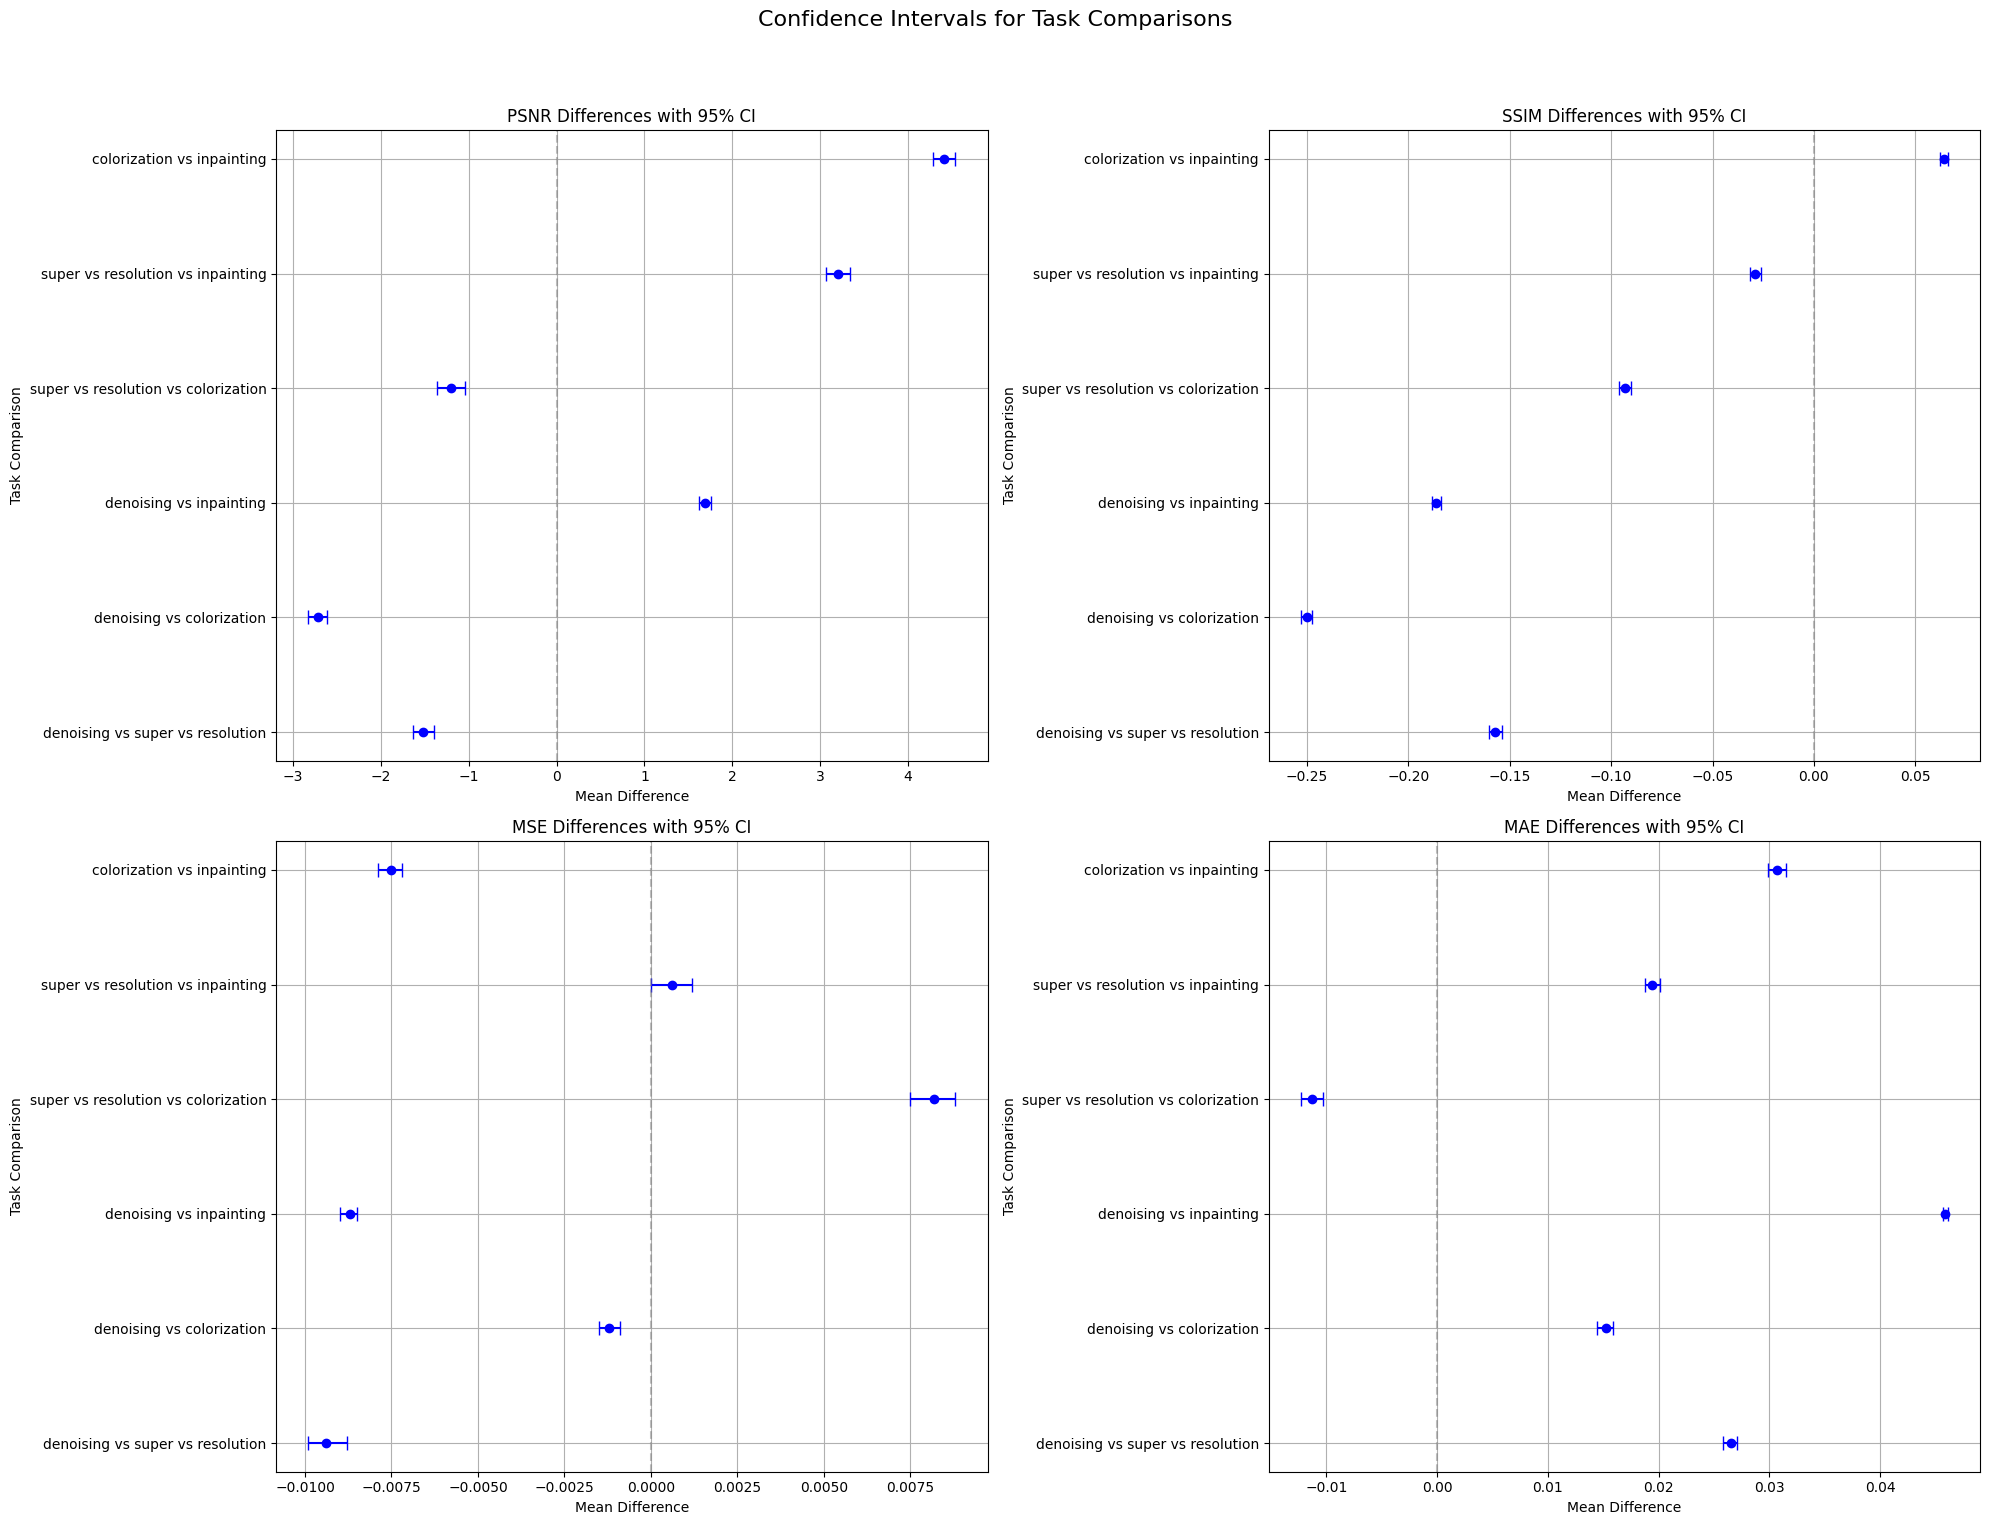

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

class ComprehensiveAnalysis:
    def __init__(self, results_dir='./results'):
        self.results_dir = results_dir
        self.tasks = ['denoising', 'super_resolution', 'colorization', 'inpainting']
        self.metrics = ['psnr', 'ssim', 'mse', 'mae']

        # Store the confidence intervals
        self.ci_data = self.create_ci_data()

    def create_ci_data(self):
        """Create structured data from our confidence intervals."""
        data = {
            'psnr': {
                'denoising_super_resolution': (-1.5140, -1.6308, -1.3958),
                'denoising_colorization': (-2.7159, -2.8210, -2.6088),
                'denoising_inpainting': (1.6900, 1.6194, 1.7611),
                'super_resolution_colorization': (-1.2010, -1.3601, -1.0440),
                'super_resolution_inpainting': (3.2063, 3.0693, 3.3403),
                'colorization_inpainting': (4.4057, 4.2799, 4.5344),
            },
            'ssim': {
                'denoising_super_resolution': (-0.1572, -0.1605, -0.1538),
                'denoising_colorization': (-0.2502, -0.2530, -0.2474),
                'denoising_inpainting': (-0.1862, -0.1886, -0.1839),
                'super_resolution_colorization': (-0.0931, -0.0962, -0.0901),
                'super_resolution_inpainting': (-0.0290, -0.0317, -0.0263),
                'colorization_inpainting': (0.0640, 0.0621, 0.0660),
            },
            'mse': {
                'denoising_super_resolution': (-0.0094, -0.0099, -0.0088),
                'denoising_colorization': (-0.0012, -0.0015, -0.0009),
                'denoising_inpainting': (-0.0087, -0.0090, -0.0085),
                'super_resolution_colorization': (0.0082, 0.0075, 0.0088),
                'super_resolution_inpainting': (0.0006, 0.0000, 0.0012),
                'colorization_inpainting': (-0.0075, -0.0079, -0.0072),
            },
            'mae': {
                'denoising_super_resolution': (0.0265, 0.0258, 0.0271),
                'denoising_colorization': (0.0152, 0.0144, 0.0159),
                'denoising_inpainting': (0.0459, 0.0457, 0.0461),
                'super_resolution_colorization': (-0.0113, -0.0123, -0.0103),
                'super_resolution_inpainting': (0.0194, 0.0188, 0.0201),
                'colorization_inpainting': (0.0307, 0.0299, 0.0315),
            }
        }
        return data

    def plot_confidence_intervals(self):
        """Plot confidence intervals for all metrics."""
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Confidence Intervals for Task Comparisons', size=16)

        for idx, metric in enumerate(self.metrics):
            ax = axes[idx // 2, idx % 2]
            data = self.ci_data[metric]

            y_pos = np.arange(len(data))
            means = [d[0] for d in data.values()]
            errors_low = [abs(m - l) for m, l, _ in data.values()]
            errors_high = [abs(h - m) for m, _, h in data.values()]

            ax.errorbar(means, y_pos, xerr=[errors_low, errors_high], fmt='o', capsize=5, color='blue')
            ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
            ax.set_yticks(y_pos)
            ax.set_yticklabels([k.replace('_', ' vs ') for k in data.keys()])
            ax.set_title(f'{metric.upper()} Differences with 95% CI')
            ax.set_xlabel('Mean Difference')
            ax.set_ylabel('Task Comparison')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for title space
        return fig

    def run_analysis(self):
        """Run complete analysis and save results."""
        os.makedirs(self.results_dir, exist_ok=True)
        ci_fig = self.plot_confidence_intervals()
        ci_fig.savefig(os.path.join(self.results_dir, 'confidence_intervals.png'))
        print(f"Analysis complete! Results saved to {self.results_dir}")

def main():
    analyzer = ComprehensiveAnalysis()
    analyzer.run_analysis()

if __name__ == "__main__":
    main()


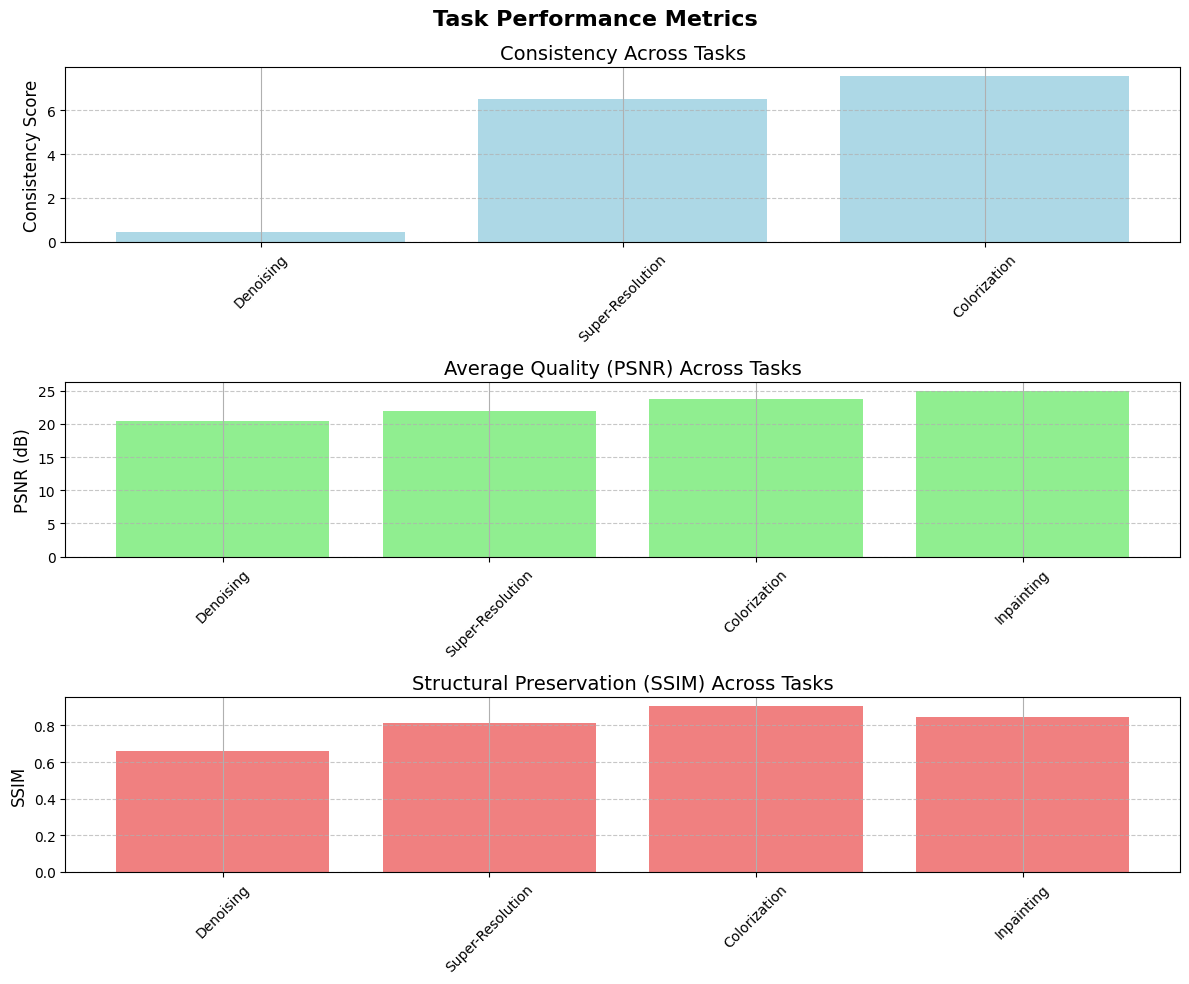

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the provided data
data = {
    'Task': ['Denoising', 'Super-Resolution', 'Colorization', 'Inpainting'],
    'Consistency': [0.439, 6.4934, 7.5822, None],
    'Average Quality (PSNR)': [20.4236, 21.9375, 23.7144, 25.0],
    'Structural Preservation (SSIM)': [0.6582, 0.8154, 0.9085, 0.8443]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Replace missing values with NaN for compatibility with numpy functions
df['Consistency'] = df['Consistency'].replace([None], np.nan)

# Set up the figure
plt.figure(figsize=(12, 10))

# Plot 1: Consistency
plt.subplot(3, 1, 1)
plt.bar(df['Task'], df['Consistency'], color='lightblue')
plt.title('Consistency Across Tasks', fontsize=14)
plt.ylabel('Consistency Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Average Quality (PSNR)
plt.subplot(3, 1, 2)
plt.bar(df['Task'], df['Average Quality (PSNR)'], color='lightgreen')
plt.title('Average Quality (PSNR) Across Tasks', fontsize=14)
plt.ylabel('PSNR (dB)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Structural Preservation (SSIM)
plt.subplot(3, 1, 3)
plt.bar(df['Task'], df['Structural Preservation (SSIM)'], color='lightcoral')
plt.title('Structural Preservation (SSIM) Across Tasks', fontsize=14)
plt.ylabel('SSIM', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Task Performance Metrics', fontsize=16, weight='bold')
plt.savefig('task_performance_metrics.png')
plt.show()
